In [2]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
from linear_ssm import StateSpace_EM
from heteroscedastic_ssm import HeteroscedasticKalmanSmoother, HeteroscedasticStateSpace_EM

In [3]:
import factors, densities

In [4]:
def proj(U, v):
    return numpy.dot(numpy.dot(v, U) / numpy.linalg.norm(U, axis=0), U.T)

def gs(N):
    V = numpy.zeros((N, N))
    A = numpy.random.randn(N,N)
    #A = numpy.eye(N)
    for d in range(N):
        v = A[:,d]
        V[:,d] = v - proj(V[:,:d], v)
        V[:,d] /= numpy.sqrt(numpy.sum(V[:,d] ** 2))
    return V


def generate_heteroscedastic_data(T, Dx, Dz, Du, sigma_z = .2, sigma_x = .05):
    params_dict = {'T': T, 'Dx': Dx, 'Dz': Dz, 'Du': Du, 'sigma_z': sigma_z, 'sigma_x': sigma_x}
    C = numpy.random.randn(Dx, Dz) / .5
    U = gs(Dx)[:Du].T
    w = numpy.random.randn(Du, Dz)
    w /= .5 * numpy.sum(numpy.abs(w), axis=1)[:,None]
    b_w = 1. * numpy.random.randn(Du)
    beta = .1e-1 * numpy.random.rand(Du)
    params_dict = {**params_dict, 'C': C, 'U': U, 'w': w, 'b_w': b_w, 'beta': beta}
    
    # Sample latent space
    z = numpy.zeros([Dz, T])
    noise_z = sigma_z * numpy.random.randn(Dz, T)
    # A = .99 * numpy.eye(Dz)
    # A[1,0] = .05
    # A[0,1] = -.05
    # b = numpy.zeros(Dz)
    # for t in range(1,T):
    #     z[:,t] = numpy.dot(A, z[:,t-1]) + b + noise_z[:,t-1]
    freq = 1 / (1000 * numpy.random.rand(Dz) + 500)
    phase = 2 * numpy.pi * numpy.random.rand(Dz)
    for idz in range(Dz): 
        z[idz] = 5*numpy.cos(2 * numpy.pi * numpy.arange(T) * freq[idz] + phase[idz]) + noise_z[idz]
    D_Sigma = 2 * beta[:,None] * numpy.cosh(numpy.dot(w, z) + b_w[:,None])
    x = numpy.zeros((Dx,T))
    mu_x = numpy.dot(C, z)
    noise_x = numpy.random.randn(Dx, T)
    for t in range(T):
        Sigma_x = sigma_x ** 2 * numpy.eye(Dx) + numpy.dot(numpy.dot(U, numpy.diag(D_Sigma[:,t])), U.T)
        L_x = numpy.linalg.cholesky(Sigma_x)
        x[:,t] = mu_x[:,t] + numpy.dot(L_x, noise_x[:,t])
    return x, z, params_dict

Text(0, 0.5, 'z1')

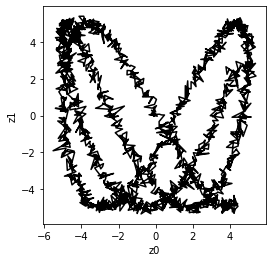

In [5]:
Dz = 3
Dx = 6
Du = 2
T = 2000
X, z, params_dict = generate_heteroscedastic_data(T, Dx, Dz, Du)
pyplot.figure(figsize=(4,4))
pyplot.plot(z[0], z[1], 'k')
pyplot.xlabel('z0')
pyplot.ylabel('z1')

Text(0, 0.5, 'X1')

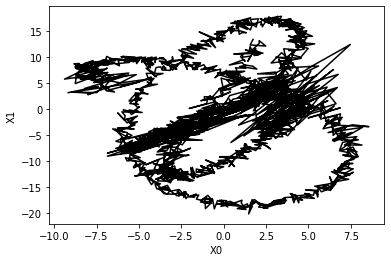

In [6]:
pyplot.plot(X[0], X[1], 'k')
pyplot.xlabel('X0')
pyplot.ylabel('X1')

In [7]:
A, b = numpy.eye(Dz), numpy.zeros(Dz)
C = params_dict['C']
d = numpy.zeros(Dx)
Qz = params_dict['sigma_z'] ** 2 * numpy.eye(Dz)
sigma_x = params_dict['sigma_x']
U = params_dict['U']
W = numpy.vstack([params_dict['b_w'], params_dict['w'].T])
beta = params_dict['beta']
hks = HeteroscedasticKalmanSmoother(X.T, A, b, Qz, C, d, U, W, beta, sigma_x)
hks.forward_path()
hks.backward_path()

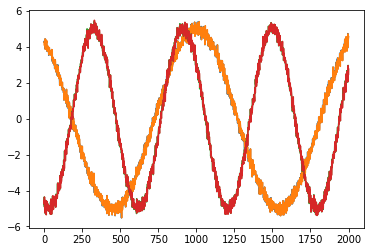

In [8]:
pyplot.plot(z.T[:,0])
pyplot.plot(hks.smoothing_density.mu[:,0])
pyplot.plot(z.T[:,1])
pyplot.plot(hks.smoothing_density.mu[:,1])

In [9]:
hssm = HeteroscedasticStateSpace_EM(X.T, Dz, Du)

In [10]:
hssm.run_em()

Iteration 1 - llk=-8398707.9
Iteration 2 - llk=-8391239.9
Iteration 3 - llk=-8391227.7


[-8398707.89929739, -8391239.883718407, -8391227.7035249]

In [68]:
hssm.get_lower_bounds()

(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
[200.         200.         200.         ...   5.74777173   4.99904294
   4.97313639]
(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
[1.77558347 1.67955081 1.62214682 ... 0.40465647 0.44734581 0.47039849]


In [45]:
R, intD_inv, intD_inv_zz, intD_inv_zx_d, intD_inv_x_Cz, omega_star = hssm.get_inv_lb(1)

(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
(2000, 3) (2000,) (2000, 3) (2000,)
[1.86219334 1.75656012 1.69648998 ... 0.40894775 0.4515015  0.47449562]


In [46]:
R.shape, intD_inv.shape, intD_inv_zz.shape, intD_inv_zx_d.shape, intD_inv_x_Cz.shape

((6, 6), (), (3, 3), (3, 6), (6,))

In [52]:
hssm.get_log_lb(1)

(array([-2.11855338, -2.24477895, -2.31892959, ..., -3.44823871,
        -3.43650285, -3.42971651]),
 array([2.39142348, 2.25020896, 2.16599157, ..., 0.42132915, 0.46245318,
        0.48474225]))

In [54]:
hssm.update_C()
hssm.C

array([[ 0.00483193, -0.00118932,  0.00033582],
       [ 0.01080241,  0.00890271, -0.01080907],
       [-0.0137167 ,  0.00072936, -0.00629364],
       [ 0.00046575,  0.00669535, -0.02889149],
       [ 0.02012836,  0.00457966,  0.0035173 ],
       [-0.00213419, -0.00344881,  0.02464044]])

In [24]:
numpy.sum(hssm.ks.smoothing_density.integrate('xx')[1:], axis=0)
#numpy.linalg.solve(hssm.Sigma_inv_zz, hssm.Sigma_inv_zx).T.shape, hssm.C.shape

array([[ 29676.34787626, -50644.60739375,  -9436.39129555],
       [-50644.60739375,  86835.91535201,  16263.92201472],
       [ -9436.39129555,  16263.92201472,   3832.3877376 ]])

In [89]:
A = numpy.sum(hssm.ks.smoothing_density.integrate('xx')[1:], axis=0) / hssm.ks.sigma_x ** 2 - hssm.Sigma_inv_zz
B = numpy.dot((hssm.ks.X - hssm.d).T, hssm.ks.smoothing_density.integrate('x')[1:])
B -= hssm.intD_inv_zx_d.T
numpy.linalg.solve(A, B.T).T

array([[-0.02291349, -0.02204157, -0.06375599],
       [ 0.01924827,  0.00789954,  0.0821896 ],
       [-0.01156744, -0.00600082, -0.07633127],
       [-0.00363307, -0.00259393, -0.03154073],
       [-0.01799849, -0.01619781, -0.09013523],
       [-0.01083863, -0.00791493, -0.05413191]])

In [57]:
hssm.update_d()
hssm.d

array([-0.33704825, -0.84637276,  1.73065078,  1.78041844,  0.82116951,
       -1.26317629])

In [104]:
hssm.intD_inv_x_Cz.shape, Du

((6,), 2)

In [10]:
hssm.compute_Q()

-8.919917243459418e+31

In [110]:
hssm.d

array([ 0.78908115, -1.99150163,  2.01261572,  0.8521397 ,  1.93452667,
        1.2314468 ])

In [28]:
import scipy
scipy.linalg.eigh(numpy.dot(X, X.T), eigvals=(hssm.Dx-hssm.Du, hssm.Dx-1))[1].shape

(6, 2)

In [69]:
hssm.update_U()

## dbeta 

In [99]:
R_D_inv = numpy.einsum('abcd,ab->bcd', hssm.R_mat, 1. / (hssm.sigma_x ** 2 + hssm.f(hssm.omega_star, hssm.beta)))
first_term = numpy.einsum('ab,ba->b', hssm.U, numpy.einsum('abc,ca->ab', R_D_inv, hssm.U))
second_term = numpy.sum(hssm.f(hssm.omega_dagger, hssm.beta) / (hssm.sigma_x ** 2 + hssm.f(hssm.omega_dagger, hssm.beta)), axis=0)
dbeta = - .5 / hssm.beta * (first_term + second_term)
dln_beta = hssm.beta * dbeta
dlnbeta

array([ -230231.61300645, -4994536.49540148])

## dsigma2 

In [120]:

phi = hssm.ks.smoothing_density.slice(range(1,hssm.T + 1))
first_term = numpy.sum(phi.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1), axis=0)
R_D_inv = numpy.einsum('abcd,ab->bcd', hssm.R_mat, hssm.f(hssm.omega_star, hssm.beta) / (hssm.sigma_x ** 2 + hssm.f(hssm.omega_star, hssm.beta)))
second_term = numpy.sum(numpy.einsum('ab,ba->b', hssm.U, numpy.einsum('abc,ca->ab', R_D_inv, hssm.U)))
third_term = numpy.sum(1./ hssm.sigma_x ** 2 + hssm.f(hssm.omega_dagger, hssm.beta))
fourth_term = hssm.T * (hssm.Dx - hssm.Du) / hssm.sigma_x ** 2
dsigma2 = .5 / hssm.sigma_x ** 4 * (first_term + second_term) - .5 * third_term - fourth_term
dlnsigma2 = hssm.sigma_x ** 2 * dsigma2
dlnsigma2

-18563401.74387695

In [ ]:
def update_parameters(self, params):
    num_params = 0
    self.W = params[:(self.Dz + 1) * self.Du].reshape((self.Dz + 1, self.Du))
    num_params += (self.Dz + 1) * self.Du
    self.beta = numpy.exp(params[num_params:num_params + self.Du])
    num_params += self.Du
    self.sigma_x = numpy.sqrt(numpy.exp(params[num_params]))
    
def gradient_function(self, params):
    self.update_parameters(params)
    self.get_lower_bounds()
    Qm = self.get_Qm()
    grad_Qm = self.get_gradients()
    return -Qm, -grad_Qm

def get_gradients(self):
    dW = self.get_dW()
    dlnbeta = self.get_dlnbeta()
    dlnsigma2 = self.get_dlnsigma2()
    return numpy.concatenate([dW,dlnbeta,dlnsigma2])


def get_dW(self):
    

In [143]:
self = hssm
# params w, b, log(beta), log(sigma2_x)
sigma2_x = self.sigma_x ** 2
beta = self.beta
R_mat = numpy.sum(self.R_mat, axis=0)
mat1 = -self.C
vec1 = self.ks.X - hssm.d[None]
phi = hssm.ks.smoothing_density.slice(range(1,hssm.T + 1))
epsilon2 = numpy.sum(phi.integrate('Ax_aBx_b_inner', A_mat=mat1, a_vec=vec1, B_mat=mat1, b_vec=vec1), axis=0)
uRu = numpy.sum(numpy.einsum('ab,ba->b', self.U, numpy.einsum('abc,ca->ab', R_mat, self.U)))
ln_dets = (self.Dx - self.Du) * numpy.log(sigma2_x) + numpy.sum(numpy.log(sigma2_x + self.f(self.omega_star, beta)))
Q_m = - .5 * (epsilon2 - uRu) / sigma2_x - .5 * ln_dets

In [148]:
self.W.flatten().reshape((self.Dz + 1, self.Du))

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [144]:
numpy.sum(numpy.log(sigma2_x + self.f(self.omega_star, beta)))

74947.04437205783

In [142]:
numpy.dot(hssm.U.T, hssm.U)

array([[1.00000000e+00, 3.24777156e-16],
       [3.24777156e-16, 1.00000000e+00]])

In [66]:
import scipy
scipy.linalg.eigh(hssm.R_mat[0], eigvals=(hssm.Dx-1,hssm.Dx-1))

(array([30935.97734228]),
 array([[-0.51254974],
        [-0.26659304],
        [-0.20113198],
        [-0.51995526],
        [-0.1492633 ],
        [-0.57717748]]))

In [110]:
U = numpy.eye(Dx)[:,:3]

In [121]:
U_not_i = numpy.delete(U, [1], axis=1)
V = hssm.partial_gs(U_not_i)

In [134]:
VRV = numpy.dot(numpy.dot(V.T, hssm.R_mat[0]), V)
alpha = scipy.linalg.eigh(VRV, eigvals=(VRV.shape[0]-1,VRV.shape[0]-1))[1]
u_new = numpy.dot(V, alpha)[0]


(6, 1)

In [40]:
hssm.compute_log_likelihood()

-40624037.6010447

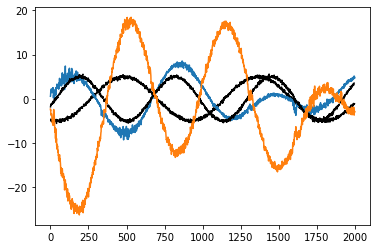

In [103]:
pyplot.plot(z.T[:,0], 'k--')
pyplot.plot(hssm.ks.smoothing_density.mu[:,0])
pyplot.plot(z.T[:,1], 'k--')
pyplot.plot(hssm.ks.smoothing_density.mu[:,1])

In [120]:
A = numpy.random.randn(5,3)
B = numpy.random.randn(4,3,3)
A2 = numpy.tile(A[None], [1, 1, 1])
C1 = numpy.einsum('abc,dc->abd', B, A)
C2 = numpy.einsum('abc,adc->abd', B, A2)

In [121]:
C1 == C2

array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]]])

In [122]:
A.ndim

2